In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def prepare(data):
    data['import.start'] = pd.to_datetime(data['import.start'])
    data['import.stop'] = pd.to_datetime(data['import.stop'])
    data['created'] = pd.to_datetime(data['created'])
    data['started'] = pd.to_datetime(data['started'])
    data['finished'] = pd.to_datetime(data['finished'])
    
    data['starttime'] = (data['started'] - data['created']).dt.total_seconds() 
    data['dockertime'] = (data['finished'] - data['started']).dt.total_seconds() 
    data['importtime'] = (data['import.stop'] - data['import.start']).dt.total_seconds() 
    
    started_temp = pd.DataFrame()
    docker_temp = pd.DataFrame()
    import_temp = pd.DataFrame()
    
    for i in range(8,29,5):
        started_temp.insert(range(8,29,5).index(i), "", (pd.to_datetime(data.iloc[:, i+1]) - pd.to_datetime(data.iloc[:, i])).dt.total_seconds() , True)
        docker_temp.insert(range(8,29,5).index(i), "", (pd.to_datetime(data.iloc[:, i+2]) - pd.to_datetime(data.iloc[:, i+1])).dt.total_seconds() , True)
        import_temp.insert(range(8,29,5).index(i), "", (pd.to_datetime(data.iloc[:, i+4]) - pd.to_datetime(data.iloc[:, i+3])).dt.total_seconds() , True)
        
    
    started_temp.columns = ['starttime{}'.format(i) for i in range(1, 6)]
    docker_temp.columns = ['dockertime{}'.format(i) for i in range(1, 6)]
    import_temp.columns = ['importtime{}'.format(i) for i in range(1, 6)]
    
    data = pd.concat([data, started_temp, docker_temp, import_temp], axis=1)
    
    return data

In [4]:
vanilla_approach = pd.read_csv(f"data/vanilla_approach/run10.csv")
all_top_10 = pd.read_csv(f"data/all_top_10/run10.csv")
cluster_top_10 = pd.read_csv(f"data/cluster_top_10/run10.csv")

In [5]:
for run in range(9, 0, -1):
    vanilla_approach = pd.concat([vanilla_approach, pd.read_csv(f"data/vanilla_approach/run0{run}.csv")])
    all_top_10 = pd.concat([all_top_10, pd.read_csv(f"data/all_top_10/run0{run}.csv")])
    cluster_top_10 = pd.concat([cluster_top_10, pd.read_csv(f"data/cluster_top_10/run0{run}.csv")])

In [6]:
vanilla_approach = prepare(vanilla_approach)
all_top_10 = prepare(all_top_10)
cluster_top_10 = prepare(cluster_top_10)

In [7]:
print(vanilla_approach['buldingtime'].describe())
print(all_top_10['buldingtime'].describe())
print(cluster_top_10['buldingtime'].describe())

count    2070.000000
mean       43.872947
std        96.535268
min         1.100000
25%         3.600000
50%        11.700000
75%        23.200000
max       655.900000
Name: buldingtime, dtype: float64
count    2070.000000
mean       14.138261
std        41.386941
min         1.200000
25%         3.000000
50%         7.700000
75%        11.375000
max       526.000000
Name: buldingtime, dtype: float64
count    2070.000000
mean       10.193527
std        25.575314
min         1.000000
25%         3.800000
50%         7.900000
75%        10.600000
max       400.000000
Name: buldingtime, dtype: float64


In [8]:
print(vanilla_approach['starttime'].describe())
print(all_top_10['starttime'].describe())
print(cluster_top_10['starttime'].describe())

count    2070.000000
mean        2.377417
std         0.693898
min         1.135387
25%         1.911363
50%         2.081936
75%         2.707737
max         7.351260
Name: starttime, dtype: float64
count    2070.000000
mean        2.422666
std         0.654609
min         1.206953
25%         2.007425
50%         2.144118
75%         2.697853
max         7.388799
Name: starttime, dtype: float64
count    2070.000000
mean        2.212326
std         0.647975
min         1.600626
25%         1.826340
50%         1.944655
75%         2.316585
max         6.446158
Name: starttime, dtype: float64


In [9]:
#toplot = pd.DataFrame({'values': pd.concat([vanilla_approach.starttime, all_top_10.starttime, cluster_top_10.starttime], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})
toplot = pd.DataFrame({'values': pd.concat([vanilla_approach['starttime1'], vanilla_approach['starttime2'], vanilla_approach['starttime3'], vanilla_approach['starttime4'], vanilla_approach['starttime5'],
               all_top_10['starttime1'], all_top_10['starttime2'], all_top_10['starttime3'], all_top_10['starttime4'], all_top_10['starttime5'],
               cluster_top_10['starttime1'], cluster_top_10['starttime2'], cluster_top_10['starttime3'], cluster_top_10['starttime4'], cluster_top_10['starttime5']], ignore_index=True), 
            'what': ['vanilla_approach'] * 5 * len(vanilla_approach) + ['all_top_10'] * 5 * len(all_top_10) + ['cluster_top_10'] * 5 * len(cluster_top_10)})

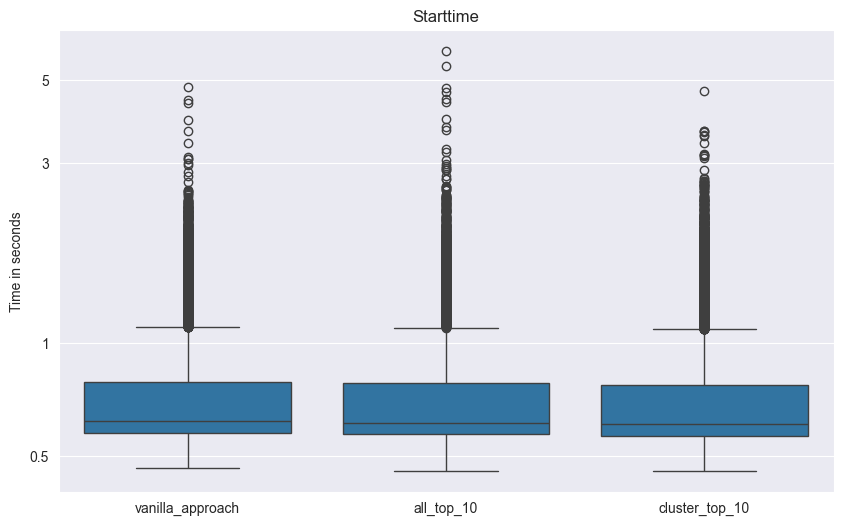

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='what', y='values', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.title('Starttime')
plt.yscale('log')
plt.yticks([0.5, 1, 3, 5],[0.5, 1, 3, 5])
plt.show()

In [11]:
toplot = pd.DataFrame({'values': pd.concat([vanilla_approach.buldingtime, all_top_10.buldingtime, cluster_top_10.buldingtime], ignore_index=True), 'what': ['vanilla_approach'] * len(vanilla_approach) + ['all_top_10'] * len(all_top_10) + ['cluster_top_10'] * len(cluster_top_10)})

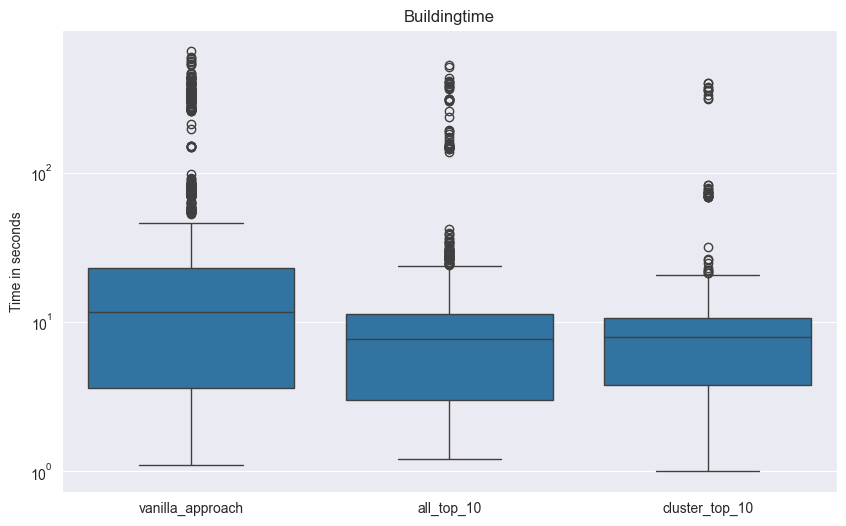

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='what', y='values', data=toplot)
plt.xlabel('')
plt.ylabel('Time in seconds')
plt.title('Buildingtime')
plt.yscale('log')
#plt.yticks([0.5, 1, 3, 5],[0.5, 1, 3, 5])
plt.show()

In [13]:
install = pd.read_csv("experiments/installations.csv")
install_libaries = pd.DataFrame()
for index, row in install.iterrows():
    if pd.isna(row[1]):
        ins = set()
    else: 
        ins = set(row[1].split(";"))
    all = set(row[2].split(";"))
    if pd.isna(row[3]):
        clu = set()
    else: 
        clu = set(row[3].split(";"))
    install_libaries = pd.concat([install_libaries, pd.DataFrame([[len(ins), len(ins.intersection(all)), len(ins.intersection(clu))]])], ignore_index=True)
install_libaries.columns = ['toInstall', 'AlreayInstalled_all', 'AlreayInstalled_cluster']


/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_6215/3142692610.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(row[1]):
/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_6215/3142692610.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ins = set(row[1].split(";"))
/var/folders/86/fyd29lqj0033vg6drb2b412m0000gn/T/ipykernel_6215/3142692610.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all = 

In [14]:
print(install_libaries.toInstall.describe())
print((install_libaries.toInstall - install_libaries.AlreayInstalled_all).describe())
print((install_libaries.toInstall - install_libaries.AlreayInstalled_cluster).describe())

count    207.000000
mean       1.434783
std        1.489232
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        7.000000
Name: toInstall, dtype: float64
count    207.000000
mean       0.570048
std        0.888804
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        5.000000
dtype: float64
count    207.000000
mean       0.048309
std        0.256156
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        2.000000
dtype: float64
